In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from matplotlib.image import imread
import pandas as pd
from PIL import Image
import cv2
import zipfile
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image
import warnings
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
print("New working directory:", os.getcwd())#zip_path = 'drive/MyDrive/CSE 151A Final Project/FracAtlas.zip'
zip_path = 'FracAtlas.zip'
extract_dir = 'fracatlas_extracted'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

images_dir = os.path.join(extract_dir, 'FracAtlas/images')
annotations_dir = os.path.join(extract_dir, 'FracAtlas/Annotations/YOLO')
# Checked to see if each image has a corresponding label

categories = ['Fractured', 'Non_fractured']

for cat in categories:
    category_path = os.path.join(images_dir, cat)

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

New working directory: /content


In [3]:
images_dir = 'fracatlas_extracted/FracAtlas/images'
annotations_dir = 'fracatlas_extracted/FracAtlas/Annotations/YOLO'

images = []
labels = []

for category in os.listdir(images_dir):
    category_path = os.path.join(images_dir, category)

    if not os.path.isdir(category_path):
        continue

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            if os.path.exists(annotation_path):
                img_path = os.path.join(category_path, img_file)
                images.append(img_path)
                labels.append(category)
            else:
                print(f"No annotation found for {img_file} at {annotation_path}.")

data_dict_old = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)} image paths and {len(labels)} labels in organized data")

4083 image paths and 4083 labels in organized data


In [4]:
def preprocess(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0 # normalize pixel values
        return img_array
    except (OSError, IOError) as e:
        warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
        return None

images = []
labels = []

for img_path, label in zip(data_dict_old["inputs"], data_dict_old["labels"]):
    img = preprocess(img_path)
    if img is not None:
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

data_dict = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)}/{len(data_dict_old['inputs'])} images processed")

<ipython-input-4-a56fe80e6e2b>:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004285.jpg. Error: image file is truncated (9 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
<ipython-input-4-a56fe80e6e2b>:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004145.jpg. Error: image file is truncated (10 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
<ipython-input-4-a56fe80e6e2b>:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004149.jpg. Error: image file is truncated (33 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
<ipython-input-4-a56fe80e6e2b>:8: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004251.jpg. Error: image file is truncated (19 bytes not processed)
  warnings

4024/4083 images processed


In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_dict["labels"])
data_dict["encoded_labels"] = encoded_labels
# Function to convert image to grayscale
def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Function to normalize pixel values to [0, 1]
def normalize(image):
    return image / 255.0

# Function to standardize the image data, mean=0 and std=1
def standardize(image):
    mean = np.mean(image)
    std = np.std(image)
    standardized_image = (image - mean) / std
    return standardized_image
# Convert images to grayscale and save
def convert_and_save_grayscale_images(folder_path, save_folder, target_size=(224, 224)):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)  # Make sure save folder exists

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)

        # Skip over corrupt images
        if image is None:
            warnings.warn(f"Skipping corrupt or unreadable image: {image_path}")
            continue

        image_resized = cv2.resize(image, target_size)

        # Convert to grayscale
        grayscale_image = convert_to_grayscale(image_resized)

        # Save the grayscale image
        processed_image_path = os.path.join(save_folder, f"grayscale_{i}.npy")
        np.save(processed_image_path, grayscale_image)

        # Free up memory
        del image, grayscale_image

    print("Grayscale conversion completed.")

# Normalize the grayscale images
def normalize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        grayscale_image = np.load(image_path)

        # Normalize the grayscale image
        normalized_image = normalize(grayscale_image)

        # Save the normalized image
        processed_image_path = os.path.join(save_folder, f"normalized_{i}.npy")
        np.save(processed_image_path, normalized_image)
    print("Normalization completed.")

# Standardize the normalized images
def standardize_and_save_images(folder_path, save_folder):
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.npy')]

    for i, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        normalized_image = np.load(image_path)

        # Standardize the normalized image
        standardized_image = standardize(normalized_image)

        # Save the standardized image
        processed_image_path = os.path.join(save_folder, f"standardized_{i}.npy")
        np.save(processed_image_path, standardized_image)

        # Free up memory
        del normalized_image, standardized_image

    print("Standardization completed.")

In [6]:
!ls fracatlas_extracted/FracAtlas/images/

!ls 'fracatlas_extracted/FracAtlas/images/Fractured'

Fractured  Non_fractured
IMG0000019.jpg	IMG0001870.jpg	IMG0002384.jpg	IMG0002504.jpg	IMG0002651.jpg	IMG0003419.jpg
IMG0000025.jpg	IMG0001916.jpg	IMG0002385.jpg	IMG0002505.jpg	IMG0002652.jpg	IMG0003420.jpg
IMG0000044.jpg	IMG0001933.jpg	IMG0002386.jpg	IMG0002506.jpg	IMG0002653.jpg	IMG0003458.jpg
IMG0000057.jpg	IMG0001934.jpg	IMG0002387.jpg	IMG0002507.jpg	IMG0002664.jpg	IMG0003459.jpg
IMG0000058.jpg	IMG0001938.jpg	IMG0002388.jpg	IMG0002508.jpg	IMG0002668.jpg	IMG0003466.jpg
IMG0000059.jpg	IMG0001939.jpg	IMG0002389.jpg	IMG0002509.jpg	IMG0002701.jpg	IMG0003467.jpg
IMG0000092.jpg	IMG0001948.jpg	IMG0002390.jpg	IMG0002510.jpg	IMG0002704.jpg	IMG0003477.jpg
IMG0000100.jpg	IMG0001964.jpg	IMG0002391.jpg	IMG0002511.jpg	IMG0002705.jpg	IMG0003509.jpg
IMG0000142.jpg	IMG0001965.jpg	IMG0002392.jpg	IMG0002512.jpg	IMG0002731.jpg	IMG0003510.jpg
IMG0000143.jpg	IMG0001970.jpg	IMG0002393.jpg	IMG0002513.jpg	IMG0002732.jpg	IMG0003519.jpg
IMG0000144.jpg	IMG0001971.jpg	IMG0002394.jpg	IMG0002514.jpg	IMG0002737.jpg	

In [7]:
frac_path = '/content/Processed/Final/Processed_Fractured_Final'
unfrac_path = '/content/Processed/Final/Processed_Non_Fractured_Final'

In [8]:
fractured_path = 'fracatlas_extracted/FracAtlas/images/Fractured'
non_fractured_path = 'fracatlas_extracted/FracAtlas/images/Non_fractured'

# Folders to save the processed images for fractured and non-fractured
grayscale_fractured_folder = 'Processed/Grayscale/Processed_Fractured_Grayscale'
grayscale_non_fractured_folder = 'Processed/Grayscale/Processed_Non_Fractured_Grayscale'

normalized_fractured_folder = 'Processed/Normalize/Processed_Fractured_Normalized'
normalized_non_fractured_folder = 'Processed/Normalize/Processed_Non_Fractured_Normalized'

standardized_fractured_folder = 'Processed/Final/Processed_Fractured_Final'
standardized_non_fractured_folder = 'Processed/Final/Processed_Non_Fractured_Final'

In [9]:
# Convert all fractured and non-fractured images to grayscale and save
convert_and_save_grayscale_images(fractured_path, grayscale_fractured_folder)
convert_and_save_grayscale_images(non_fractured_path, grayscale_non_fractured_folder)

# Normalize grayscale images for both fractured and non-fractured categories
normalize_and_save_images(grayscale_fractured_folder, normalized_fractured_folder)
normalize_and_save_images(grayscale_non_fractured_folder, normalized_non_fractured_folder)

# Standardize normalized images for both fractured and non-fractured categories
standardize_and_save_images(normalized_fractured_folder, standardized_fractured_folder)
standardize_and_save_images(normalized_non_fractured_folder, standardized_non_fractured_folder)

print("All preprocessing steps completed for both fractured and non-fractured images.")

Grayscale conversion completed.
Grayscale conversion completed.
Normalization completed.
Normalization completed.
Standardization completed.
Standardization completed.
All preprocessing steps completed for both fractured and non-fractured images.


In [10]:
# load fractured and unfractured images into arrays
fracArr = []
unfracArr = []
for file in os.listdir(frac_path):
  if file.endswith(".npy"):
    fracArr.append(np.load(os.path.join(frac_path, file)))
for file in os.listdir(unfrac_path):
  if file.endswith(".npy"):
    unfracArr.append(np.load(os.path.join(unfrac_path, file)))

In [11]:
# combine images and true/false values into one array
dataset = []
data_extra = []
for i in range(len(fracArr)):
  dataset.append([fracArr[i], True])
  dataset.append([unfracArr[i], False])
for i in range(len(fracArr), len(unfracArr)):
  data_extra.append([unfracArr[i], False])

In [12]:
# get X and y arrays from the dataset
dataset = np.array(dataset, dtype=object)
X = dataset[:,0]
y = dataset[:,1].astype('bool')

In [13]:
# shuffle and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=3**-2, random_state=42)


In [14]:
# append the extra unfractured images to the training dataset
data_extra = np.array(data_extra, dtype=object)
data_train = np.column_stack((X_train, y_train))
data_train = np.append(data_train, data_extra, axis=0)
random.seed(42)
random.shuffle(data_train)
X_train = data_train[:,0]
y_train = [bool(d) for d in data_train[:,1]]

In [15]:
# # Convert labels from boolean to integers (0 and 1)
# y_train = y_train.astype(int)
# y_val = y_val.astype(int)
# y_test = y_test.astype(int)

In [16]:
from imblearn.over_sampling import SMOTE

# reshape array to use with smote
shape_orig = X_train[0].shape
X_train = np.array([np.array(val).flatten() for val in X_train])

# oversample to fix class imbalance in the training set
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# built flatten array
X_train = np.array([np.array(val).reshape(shape_orig) for val in X_train])

In [17]:
# flatten the other arrays
X_val = np.array([np.array(val) for val in X_val])
X_test = np.array([np.array(val) for val in X_test])
y_train = np.array([np.array(val) for val in y_train])
y_val = np.array([np.array(val) for val in y_val])
y_test = np.array([np.array(val) for val in y_test])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4932, 224, 224)
(4932,)
(144, 224, 224)
(144,)
(144, 224, 224)
(144,)


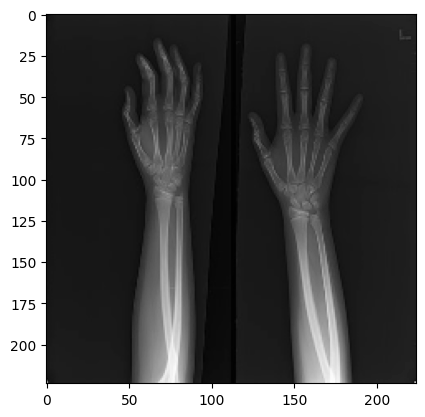

Fracture present: False


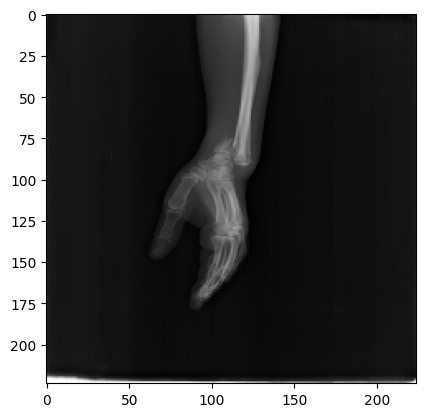

Fracture present: True


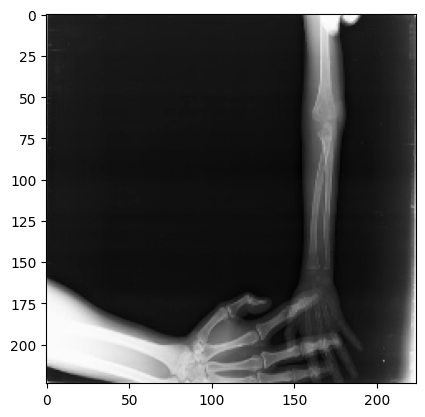

Fracture present: False


In [19]:
# print some random examples from the training set
arr = random.sample(range(0, len(X_train)), 3)
for i in arr:
  plt.imshow(X_train[i], cmap='gray')
  plt.show()
  print("Fracture present:", y_train[i])

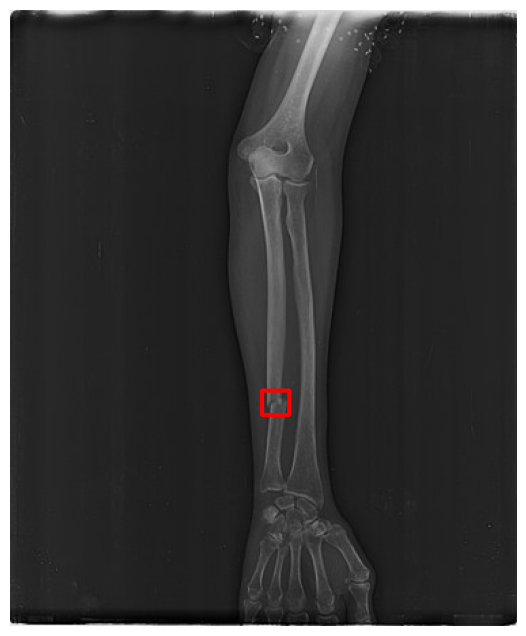

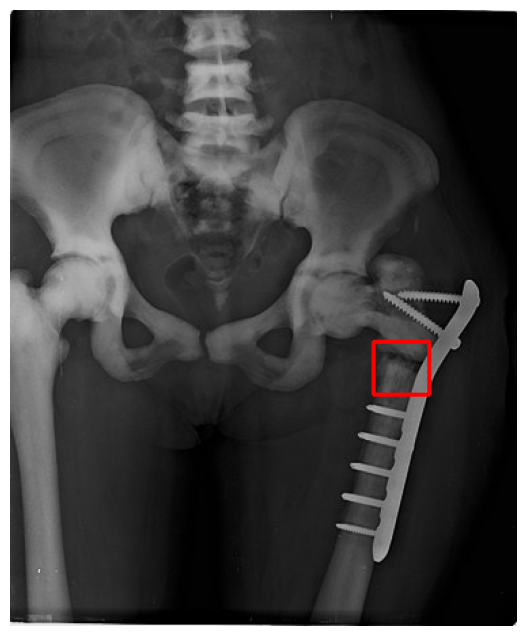

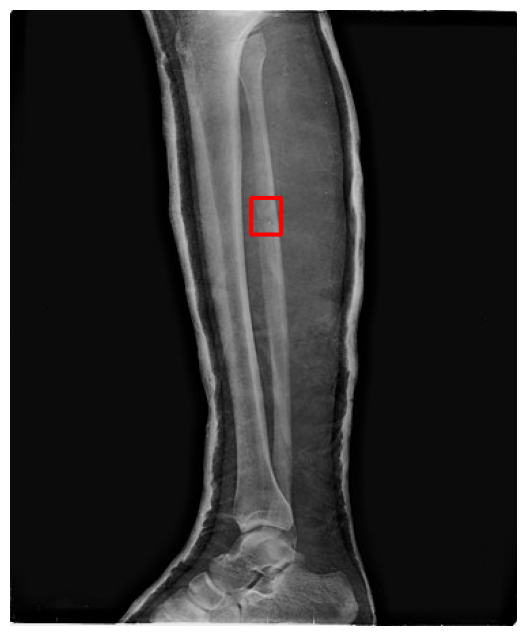

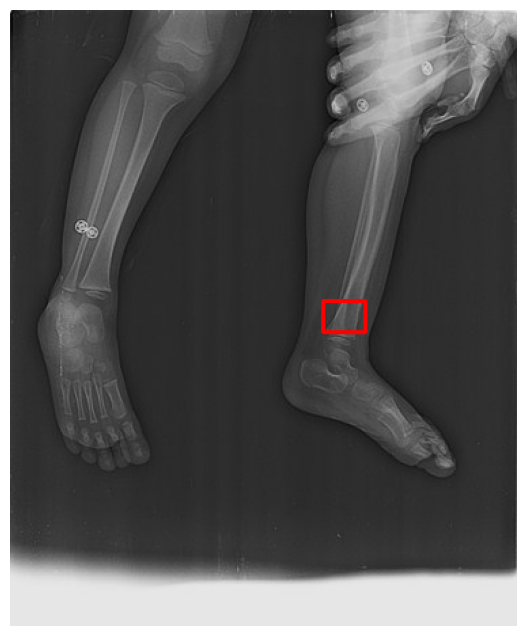

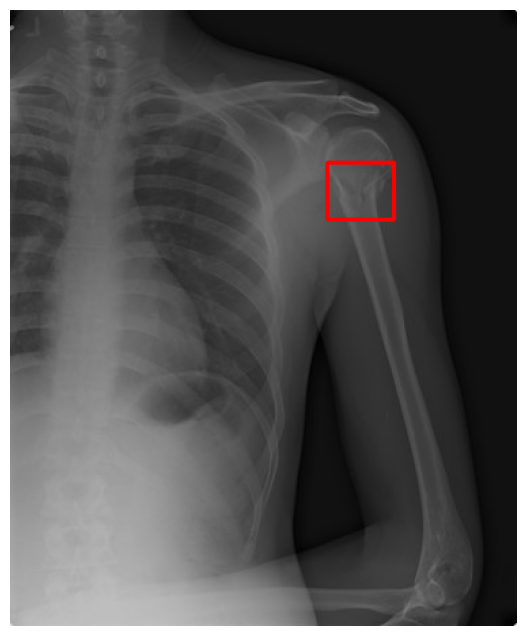

In [20]:
# Function to overlay bounding boxes on images
def draw_bounding_boxes(img_path, annotation_path, save_dir=None):
    # Loading the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # Checking if annotation exists
    if not os.path.exists(annotation_path):
        warnings.warn(f"Annotation file {annotation_path} not found. Skipping.")
        return None

    # Reading YOLO annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:

        # YOLO format: class_id, x_center, y_center, width, height (all relative)
        parts = line.strip().split()
        if len(parts) != 5:
            warnings.warn(f"Invalid annotation format in {annotation_path}. Skipping.")
            continue

        class_id, x_center, y_center, width, height = map(float, parts)

        # Converting relative coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculating box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.imsave(save_path, img)

    plt.show()

for img_path, label in zip(data_dict_old["inputs"][:5], data_dict_old["labels"][:5]):

    img_name = os.path.splitext(os.path.basename(img_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.txt')

    draw_bounding_boxes(img_path, annotation_path)

In [21]:
X_train = np.squeeze(X_train)  # Remove all unnecessary dimensions
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension (5414, 224, 224, 1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (4932, 224, 224, 1)
Shape of X_val: (144, 224, 224, 1)
Shape of X_test: (144, 224, 224, 1)


In [23]:
X_train = np.squeeze(X_train)  # Remove all unnecessary dimensions
X_val = np.squeeze(X_val)
X_test = np.squeeze(X_test)

X_train = np.expand_dims(X_train, axis=-1)  # Add channel dimension (5414, 224, 224, 1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

X_train_aug = datagen.flow(X_train, y_train, batch_size=32)

# Build the EfficientNetB0 model
def build_efficientnet():
    base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    inputs = Input(shape=(224, 224, 1))  # Accept grayscale input
    x = layers.Conv2D(3, (1, 1), padding="same")(inputs)  # Convert grayscale to RGB using a 1x1 convolution
    x = base_model(x, training=False)  # Pass the RGB images to the EfficientNet model
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

# Compile and train the model
efficientnet_model = build_efficientnet()
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

efficientnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 3)         │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,858 (15.45 MB)

 Trainable params: 1,287 (5.03 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 100s 385ms/step - accuracy: 0.4947 - loss: 0.6932 - val_accuracy: 0.4861 - val_loss: 0.6931
Epoch 2/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - accuracy: 0.5024 - loss: 0.6930 - val_accuracy: 0.5139 - val_loss: 0.6931
Epoch 3/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.4861 - val_loss: 0.6932
Epoch 4/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step - accuracy: 0.4930 - loss: 0.6939 - val_accuracy: 0.4861 - val_loss: 0.6933
Epoch 5/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.4765 - loss: 0.6937 - val_accuracy: 0.4861 - val_loss: 0.6934
Epoch 6/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.4882 - loss: 0.6938 - val_accuracy: 0.4861 - val_loss: 0.6932
Epoch 7/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/step - accuracy: 0.5130 - loss: 0.6932 - val_accuracy: 0.5278 - val_loss: 0.6931
Epoch 8/15
155/155 ━━━━━━━━━━━━━━━━━━━━ 37s 175ms/step - accuracy: 0.4837 - loss: 0.6936 - va

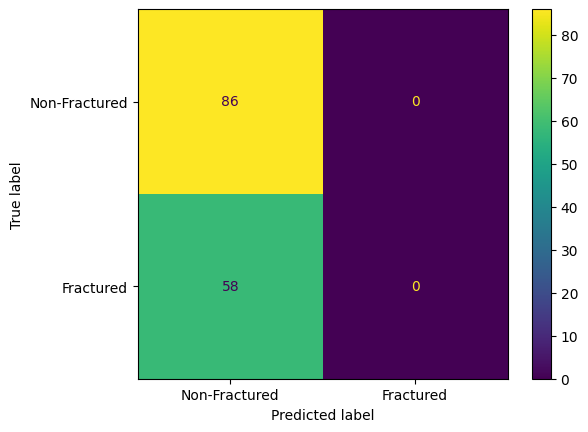

               precision    recall  f1-score   support

Non-Fractured       0.60      1.00      0.75        86
    Fractured       0.00      0.00      0.00        58

     accuracy                           0.60       144
    macro avg       0.30      0.50      0.37       144
 weighted avg       0.36      0.60      0.45       144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
history = efficientnet_model.fit(
    X_train_aug,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)

# Evaluate the model on the test set
test_loss, test_accuracy = efficientnet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Confusion matrix
y_pred = (efficientnet_model.predict(X_test) > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fractured", "Fractured"])
disp.plot(cmap="viridis")
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=["Non-Fractured", "Fractured"]))

In [25]:
# Evaluate on test data
test_loss, test_accuracy = efficientnet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5849 - loss: 0.6929
Test Loss: 0.6928449869155884, Test Accuracy: 0.5972222089767456


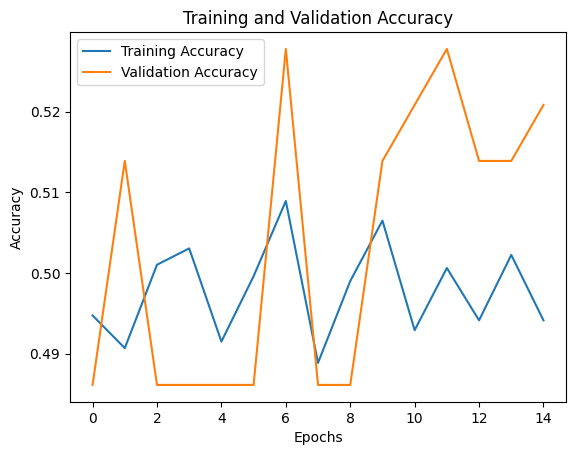

In [26]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()